<a href="http://agrum.org" target="blank"><img src="http://agrum.gitlab.io/theme/img/logoAgrum.png" align="left" style="height:100px"/></a><a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

In [1]:
import pandas
import os
import math
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from pyAgrum.lib.bn2roc import showROC_PR

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import pandas as pd

# Titanic: Machine Learning from Disaster

This notebook is an introduction to the [Kaggle titanic challenge](https://www.kaggle.com/c/titanic). The goal here is not to produce the best possible classifier, at least not yet, but to show how pyAgrum and Bayesian networks can be used to easily and quickly explore and understand data.

To undestand this notebook, basic knowledge of Bayesian networks is required. If you are looking for an introduction to pyAgrum, check [this notebook](http://www-desir.lip6.fr/~phw/aGrUM/docs/last/notebooks/Tutorial.ipynb.html).

This notebook present three different Bayesien Networks techniques to answer the Kaggle Titanic challenge. The first approach we will answer the challenge without using the training set and we will only use our prior knowledge about shipwrecks. In the second approach we will only use the training set with pyAgrum's machine learning algorithms. Finally, in the third approach we will use both prior knowledge about shipwrecks and machine learning.

Before we start, some disclaimers about aGrUM and pyAgrum. 

**aGrUM** is a C++ library designed for easily building applications using graphical models such as Bayesian networks, influence diagrams, decision trees or Markov decision processes. 

**pyAgrum** is a Python wrapper for the C++ aGrUM library. It provides a high-level interface to the part of aGrUM allowing to create, handle and make computations into Bayesian networks. The module mainly is an application of the [SWIG](http://www.swig.org/) interface generator. Custom-written code is added to simplify and extend the aGrUM API.

Both projects are [open source](https://gitlab.com/agrumery/aGrUM/blob/master/LICENSE) and can be freely downloaded from [aGrUM's gitlab repository](https://gitlab.com/agrumery/aGrUM) or installed using [pip or anaconda](http://agrum.gitlab.io/pages/pyagrum.html).

If you have questions, remarks or suggestions, feel free to ask us on [info@agrum.org](mailto:info@agrum.org).

## Pretreatment
We will be using [pandas](http://pandas.pydata.org/) to setup the learning data to fit with pyAgrum requirements.

In [2]:
traindf=pandas.read_csv('res/titanic/train.csv')                       

testdf=pandas.merge(pandas.read_csv('res/titanic/test.csv'),
                   pandas.read_csv('res/titanic/gender_submission.csv'),
                   on="PassengerId")

This merges both the test base with the fact that a passager has survived or not.

In [3]:
traindf.var()

/var/folders/0n/lmbpsyrj4ln7312yb0fpstkw0000gn/T/ipykernel_5140/1580937410.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  traindf.var()


PassengerId    66231.000000
Survived           0.236772
Pclass             0.699015
Age              211.019125
SibSp              1.216043
Parch              0.649728
Fare            2469.436846
dtype: float64

In [4]:
for k in traindf.keys():
    print('{0}: {1}'.format(k, len(traindf[k].unique())))

PassengerId: 891
Survived: 2
Pclass: 3
Name: 891
Sex: 2
Age: 89
SibSp: 7
Parch: 7
Ticket: 681
Fare: 248
Cabin: 148
Embarked: 4


Looking at the number of unique values for each variable is necessary since Bayesian networks are discrete models. We will want to reduce the domain size of some discrete varaibles (like age) and discretize continuous variables (like Fare).

For starters you can filter out variables with a large number of values. Choosing a large number will have an impact on performances, which boils down to how much CPU and RAM you have at your disposal. Here, we choose to filter out any variable with more than 10 different outcomes.

In [5]:
for k in traindf.keys():
    if len(traindf[k].unique())<=15:
        print(k)

Survived
Pclass
Sex
SibSp
Parch
Embarked


This leaves us with 6 variables, not much but still enough to learn a Bayesian network. Will just add one more variable by reducing the cardinality of the Age variable.

In [6]:
testdf=pandas.merge(pandas.read_csv('res/titanic/test.csv'),
                    pandas.read_csv('res/titanic/gender_submission.csv'),
                    on="PassengerId")


def forAge(row):
    try:
        age = float(row['Age'])
        if age < 1:
            #return '[0;1['
            return 'baby'
        elif age < 6:
            #return '[1;6['
            return 'toddler'
        elif age < 12:
            #return '[6;12['
            return 'kid'
        elif age < 21:
            #return '[12;21['
            return 'teen'
        elif age < 80:
            #return '[21;80['
            return 'adult'
        else:
            #return '[80;200]'
            return 'old'
    except ValueError:
        return np.nan
    
def forBoolean(row, col):
    try:
        val = int(row[col])
        if row[col] >= 1:
            return "True"
        else:
            return "False"
    except ValueError:
        return "False"
    
def forGender(row):
    if row['Sex'] == "male":
        return "Male"
    else:
        return "Female"
        

testdf

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


When pretreating data, you will want to wrap your changes inside a function, this will help you keep track of your changes and easily compare them.

In [7]:
def pretreat(df):
    if 'Survived' in df.columns:
        df['Survived'] = df.apply(lambda row: forBoolean(row, 'Survived'), axis=1)
    df['Age'] = df.apply(forAge, axis=1)
    df['SibSp'] = df.apply(lambda row: forBoolean(row, 'SibSp'), axis=1)
    df['Parch'] = df.apply(lambda row: forBoolean(row, 'Parch'), axis=1)
    df['Sex'] = df.apply(forGender, axis=1)
    droped_cols = [col for col in ['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin'] if col in df.columns]
    df = df.drop(droped_cols, axis=1)
    df = df.rename(index=str, columns={'Sex': 'Gender', 'SibSp': 'Siblings', 'Parch': 'Parents'})
    df.dropna(inplace=True)
    return df

traindf = pandas.read_csv('res/titanic/train.csv')
testdf  = pandas.merge(pandas.read_csv('res/titanic/test.csv'),
                       pandas.read_csv('res/titanic/gender_submission.csv'),
                       on="PassengerId")

traindf = pretreat(traindf)
testdf = pretreat(testdf)

We will need to save this intermediate learning database, since pyAgrum accepts only files as inputs. As a rule of thumb, save your CSV using comma as separators and do not quote values when you plan to use them with pyAgrum.

In [8]:
import csv
traindf.to_csv('res/titanic/post_train.csv', index=False)
testdf.to_csv('res/titanic/post_test.csv', index=False)

## Modeling withtout learning
In some cases, we might not have any data to learn from. In such cases, we can rely on experts to provide correlation between variables and conditional probabilities.

It can be simpler to start with a simple topography, leaving room to add more complexe correlations as the model is confonted aginst data. Here, we will use three hypothesis: 
- All variables are independent conditionnaly to each other given the fact that a passenger has survive or not.
- Women and children are more likelly to survive.
- The more sibling or parents abord, the less likelly the passenger will survive.

The first assumption results in the following DAG for our Bayesian network:

In [9]:
bn = gum.BayesNet("Surviving Titanic")
bn =gum.fastBN("Age{baby|toddler|kid|teen|adult|old}<-Survived{False|True}->Gender{Female|Male};Siblings{False|True}<-Survived->Parents{False|True}")
print(bn.variable("Survived"))
print(bn.variable("Age"))
print(bn.variable("Gender"))
print(bn.variable("Siblings"))
print(bn.variable("Parents"))

bn

Survived<False,True>
Age<baby,toddler,kid,teen,adult,old>
Gender<Female,Male>
Siblings<False,True>
Parents<False,True>


(gum::BayesNet<double>@0x7fd6d129de00) BN{nodes: 5, arcs: 4, domainSize: 96, dim: 26}

Hypothesis two and three can help us define the parameters for this Bayesian network. Remember that we assume that we do not have any data to learn from. So we will use simple definition such as "a women is 10 times more likeliy to survive than a man". We can then normalize the values to obtain a proper conditional probability distribution.

This technique may not be the most precise or scientifically sounded, it however has the advantage to be easy to use.

In [10]:
bn.cpt('Survived')[:] = [100, 1]
bn.cpt('Survived').normalizeAsCPT()
bn.cpt('Survived')

(gum::Potential<double>@0x7fd6a1a0b1b0) 
  Survived         |
False    |True     |
---------|---------|
 0.9901  | 0.0099  |

In [11]:
bn.cpt('Age')[{'Survived':0}] = [ 1, 1, 1, 10, 10, 1]
bn.cpt('Age')[{'Survived':1}] = [ 10, 10, 10, 1, 1, 10]
bn.cpt('Age').normalizeAsCPT()
bn.cpt('Age')

(gum::Potential<double>@0x7fd6a1a0ba90) 
      ||  Age                                                      |
Surviv||baby     |toddler  |kid      |teen     |adult    |old      |
------||---------|---------|---------|---------|---------|---------|
False || 0.0417  | 0.0417  | 0.0417  | 0.4167  | 0.4167  | 0.0417  |
True  || 0.2381  | 0.2381  | 0.2381  | 0.0238  | 0.0238  | 0.2381  |

In [12]:
bn.cpt('Gender')[{'Survived':0}] = [ 1, 1]
bn.cpt('Gender')[{'Survived':1}] = [ 10, 1]
bn.cpt('Gender').normalizeAsCPT()
bn.cpt('Gender')

(gum::Potential<double>@0x7fd6a1a0bfb0) 
      ||  Gender           |
Surviv||Female   |Male     |
------||---------|---------|
False || 0.5000  | 0.5000  |
True  || 0.9091  | 0.0909  |

In [13]:
bn.cpt('Siblings')[{'Survived':0}] = [ 1, 10]
bn.cpt('Siblings')[{'Survived':1}] = [ 10, 1]
bn.cpt('Siblings').normalizeAsCPT()
bn.cpt('Siblings')

(gum::Potential<double>@0x7fd6a1a0ad10) 
      ||  Siblings         |
Surviv||False    |True     |
------||---------|---------|
False || 0.0909  | 0.9091  |
True  || 0.9091  | 0.0909  |

In [14]:
bn.cpt('Parents')[{'Survived':0}] = [ 1, 10]
bn.cpt('Parents')[{'Survived':1}] = [ 10, 1]
bn.cpt('Parents').normalizeAsCPT()
bn.cpt('Parents')

(gum::Potential<double>@0x7fd6a1a0b630) 
      ||  Parents          |
Surviv||False    |True     |
------||---------|---------|
False || 0.0909  | 0.9091  |
True  || 0.9091  | 0.0909  |

Now we can start using the Bayesian network and check that our hypothesis hold.

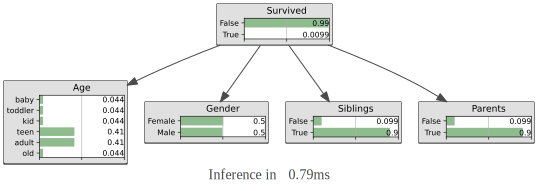

In [15]:
gnb.showInference(bn,size="10")

We can see here that most passengers (99% of them) will not survive and that we have almost as much women (50.4%) as men (49.6%). The majority of passengers are either teenagers or adults. Finally, most passenger had siblings or parents aboard.

Recall that we have not use any data to learn the Bayesian Netork's parameters and our expert did not have any knowledge about the passengers aboard the Titanic.

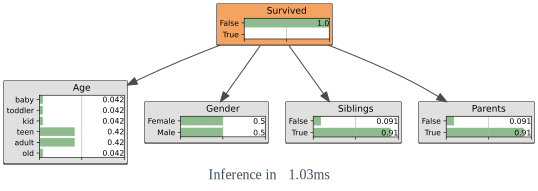

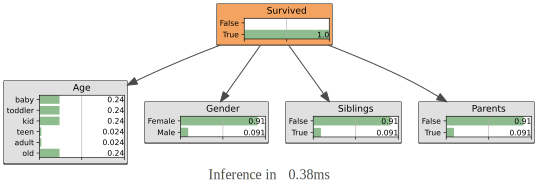

In [16]:
gnb.showInference(bn,size="10", evs={'Survived':'False'})
gnb.showInference(bn,size="10", evs={'Survived':'True'})

Here, we can see that our second and third hypothesis hold since when we enter envidence that a passenger survived, it is more likely to be a woman with no siblings or parents. On the contrary, if we observe that a passenger did not survive we can see that it is more likely to be a man with siblings or parents.

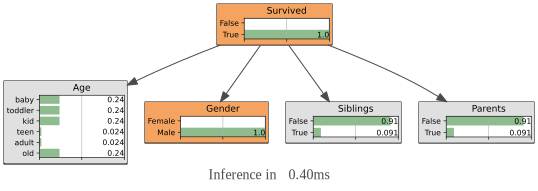

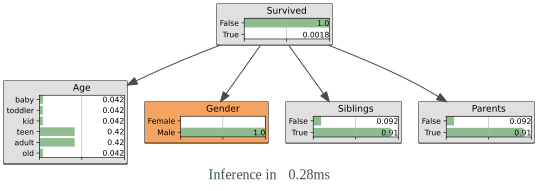

In [17]:
gnb.showInference(bn,size="10", evs={'Survived':'True', 'Gender':'Male'})
gnb.showInference(bn,size="10", evs={'Gender':'Male'})

This validates our first hypothesis: if we know that a passenger survived or not, then evidence about that passenger does not changes our belief about other variables. On the contrary, if we do not know if a passenger survived, then evidence about the passenger will change our belief about other variables, including the fact that he or she survived or not.

In [18]:
ie=gum.LazyPropagation(bn)

def init_belief(engine):
    # Initialize evidence
    for var in engine.BN().names():
        if var != 'Survived':
            engine.addEvidence(var, 0)

def update_beliefs(engine, bayesNet, row):
    # Update beliefs from a given row less the Survived variable
    for var in bayesNet.names():
        if var == "Survived":
            continue
        try:
            label = str(row.to_dict()[var])
            idx = bayesNet.variable(var).index(str(row.to_dict()[var]))
            engine.chgEvidence(var, idx)
        except gum.NotFound:
            # this can happend when value is missing is the test base.
            pass        
    engine.makeInference()
    
def is_well_predicted(engine, bayesNet, auc, row):
    update_beliefs(engine, bayesNet, row)
    marginal = engine.posterior('Survived')
    outcome = row.to_dict()['Survived']
    if outcome == "False": # Did not survived
        if marginal.toarray()[1] < auc:
            return "True Positive"
        else:
            return "False Negative"
    else: # Survived
        if marginal.toarray()[1] >= auc:
            return "True Negative"
        else:
            return "False Positive"

init_belief(ie)
ie.addTarget('Survived')
result = testdf.apply(lambda x: is_well_predicted(ie, bn, 0.5, x), axis=1)
result.value_counts(True)

True Positive     0.516746
False Positive    0.322967
False Negative    0.119617
True Negative     0.040670
dtype: float64

In [19]:
positives = sum(result.map(lambda x: 1 if x.startswith("True") else 0 ))
total = result.count()
print("{0:.2f}% good predictions".format(positives/total*100))

55.74% good predictions


This first model achieve a 55.74% of good predictions, not a good result but we have plenty of room to improve it.

## Pre-learning
We will now learn a Bayesian network from the training set without any prior knowledge about shipwreks.

Before learning a Bayesian network, we first need to create a template. This is not mandatory, however it is sometimes usefull since not all varaibles values are present in the learning base (in this example the number of relatives).

If during the learning step, the algorithm encounters an unknown value it will raise an error. This would be an issue if we wanted to automitize our classifier but, we will directly use values working with the test and learning base. This is not ideal but the objective here it to explore the data fast, not thoroughly.

To help creating de the template Bayesian network that we will use to learn our classifier, let us firt recall all the variables wa have at our disposal.

In [20]:
df = pandas.read_csv('res/titanic/post_train.csv')
for k in traindf.keys():
    print('{0}: {1}'.format(k, len(traindf[k].unique())))

Survived: 2
Pclass: 3
Gender: 2
Age: 6
Siblings: 2
Parents: 2
Embarked: 3


From here, creating the BayesNet is straitforward: for each variable we either use the `RangeVariable` class or the `LabelizedVariable`.

The `RangeVariable` class creates a discrete random variable over a range. With the `LabelizedVariable` you will need to add each label ony by one. Note however that you can pass an argument to create as much labels starting from `0`.

In [21]:
template=gum.BayesNet()
template.add(gum.LabelizedVariable("Survived", "Survived", ['False', 'True']))
template.add(gum.RangeVariable("Pclass", "Pclass",1,3))
template.add(gum.LabelizedVariable("Gender", "The passenger's gender",['Female', 'Male']))
template.add(gum.LabelizedVariable("Siblings", "Siblings",['False', 'True']))
template.add(gum.LabelizedVariable("Parents", "Parents",['False', 'True']))
template.add(gum.LabelizedVariable("Embarked", "Embarked", ['', 'C', 'Q', 'S']))
template.add(gum.LabelizedVariable("Age", "The passenger's age category", ["baby", "toddler", "kid", "teen", "adult", "old"]))             
gnb.showBN(template)

You can also let the learning algorithm create the BayesNet random variables. However please be aware that the algorithm will no be able to handle values absent from the learning database.

## Learning

We can now learn our first Bayesian network. As you will see, this is really easy.

In [22]:
file = 'res/titanic/post_train.csv'
learner = gum.BNLearner(file, template)
bn = learner.learnBN()
bn

(gum::BayesNet<double>@0x7fd6d130b200) BN{nodes: 7, arcs: 9, domainSize: 1152, dim: 78}

In a notebook, a Bayesian network will automatically be shown graphically, you can also use the helper function `gnb.showBN(bn)`.

## Exploring the data
Now that we have a BayesNet, we can start looking how the variables corelate with each other. pyAgum offer the perfect tool for that: the information graph.

In [23]:
import pyAgrum.lib.explain as explain
explain.showInformation(bn,{},size="20")

To read this graph, you must understand what the entropy of a variable means: the hightest the value the more uncertain the variable marginal probability distrubition is (maximum entropy beging the equiprobable law). The lowest the value is, the more /certain/ the law is.

A consequence of how entropy is calculated, is that entropy tends to get bigger if the random varaible has many modalities.

What the information graph tells us is that the `decade` variable has a hight entropy. Thus, we can conclude that the passengers `decade` is distributed between all of its modalities.

What it also tells us, it that high modality variables with low entropy, such as `Parch` or `SibSp`, are not evenly distributed.

Let us look at he variables marginal probability by using the `showInference()` function.

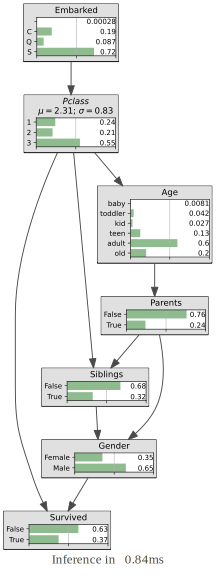

In [24]:
gnb.showInference(bn)

The `showInference()` is really usefull as it shows the marginal probability distribution for each random variable of a BayesNet.

We can now confirm what the entropy learned us: `Parch` and `SibSp` are unevenly distributed and `decade` is more evenly distributed.

Lets focus on the Kaggle challenge now, and look at the `Survived` variable. We show a single posterior using the `showPosterior()` function.

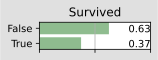

In [25]:
gnb.showPosterior(bn,evs={},target='Survived')

So more than 40% of the passenger in our learning database survived.

So how can we use this BayesNet as a classifier ? Given a set of evidence, we can infer an update posterio distribution of the target variable `Survived`.

Lets look at the odds of surviving as a man in his thirties.

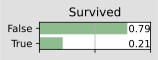

In [26]:
gnb.showPosterior(bn,evs={"Gender": "Male", "Age": 'adult'},target='Survived')

And now the odds of an old lady to survive.

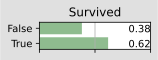

In [27]:
gnb.showPosterior(bn,evs={"Gender": "Female", "Age": 'old'},target='Survived')

Well, children and ladies first, that's right ?

One last information we will need is which variables are required to predict the `Survived` variable. To do, we will use the markov blanket of `Survived`.



In [28]:
gnb.sideBySide(bn, gum.MarkovBlanket(bn, 'Survived'), captions=["Learned Bayesian network", "Markov blanket of 'Survived'"])

The Markov Blanket of the `Survived` variable tells us that we only need to observe `Sex` and `Pclass` in order to predict `Survived`. Not really usefull here but on larger Bayesian networks it can save you a lot of time and CPU.

So how to use this BayesNet we have learned as a classifier ? We simply infer the posterior the `Survive` variable given the set of evidence we are given, and if the passanger odds of survival are above some value he will be taged as a survivor.

To compute the best value given the BayesNet and our training database, we can use the `showROC()` function.

res/titanic/post_train.csv: 100%|███████████████████████████████████████████████████████████|


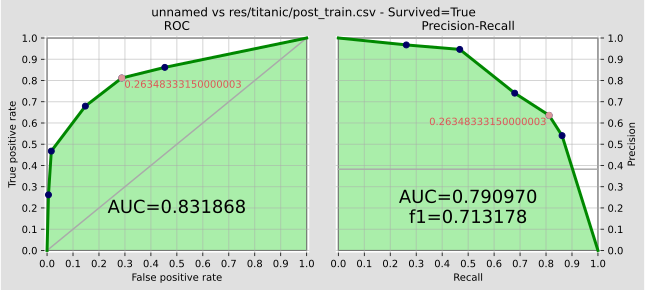

(0.8318681024322296,
 0.26348333150000003,
 0.7909697528538129,
 0.26348333150000003)

In [29]:
showROC_PR(bn, 'res/titanic/post_train.csv', 'Survived', 'True', True, True)

In [30]:
ie=gum.LazyPropagation(bn)
init_belief(ie)
ie.addTarget('Survived')
result = testdf.apply(lambda x: is_well_predicted(ie, bn, 0.157935, x), axis=1)
result.value_counts(True)

True Negative     0.363636
True Positive     0.349282
False Negative    0.287081
dtype: float64

In [31]:
positives = sum(result.map(lambda x: 1 if x.startswith("True") else 0 ))
total = result.count()
print("{0:.2f}% good predictions".format(positives/total*100))

71.29% good predictions


With 71% of good prediction, this model performs better than the first one.

# Using BNClassifier

'BNClassifier' is a BN-wrapping object that you can use as a classifier directly. It is inspired and compatible with scikitlearn methods.

In [32]:
import pyAgrum.lib.classifier as BNClassifier

In [33]:
post_train_df = pandas.read_csv('res/titanic/post_train.csv').dropna()
post_test_df = pandas.read_csv('res/titanic/post_test.csv').dropna()

In [34]:
targetColumn = 'Survived'

x_train_df = post_train_df.drop(targetColumn, axis=1)
y_train_df = post_train_df[targetColumn]
x_test_df = post_test_df.drop(targetColumn, axis=1)
y_test_df = post_test_df[targetColumn]

You create the object. Then you fit the classifier to your training dataset. The fitted classifier can now predict the class for the testing dataset.

In [35]:
bn = BNClassifier.BNClassifier()
bn.fit(x_train_df, y_train_df)
y_test_pred = bn.predict(x_test_df)

print("{0:.2f}% good predictions".format(accuracy_score(y_test_df, y_test_pred)*100))

** pyAgrum.lib.classifier.BNClassifier is deprecated in pyAgrum>0.18.1.
** A pyAgrum.skbn.BNClassifier will be used.
86.36% good predictions


You can try different parameters and use the same procedure. For example, with a a-priori-smoothing :

In [36]:
bn_prior = BNClassifier.BNClassifier(prior='laplace')
bn_prior.fit(x_train_df, y_train_df)
y_test_pred_prior = bn_prior.predict(x_test_df)

print("{0:.2f}% good predictions".format(accuracy_score(y_test_df, y_test_pred_prior)*100))

** pyAgrum.lib.classifier.BNClassifier is deprecated in pyAgrum>0.18.1.
** A pyAgrum.skbn.BNClassifier will be used.
86.36% good predictions


With a prior, the accuracy gets better. 

# Making a BN without learning data
In this last part we will combine both methods: we will force the BayesNet DAG and learn its parameters. We will assume the naive bayes hypothesis, which states that all random variables are independant conditionally to the target variable (here the variable Survived).

This results in the following (already seen) above topology.

In [37]:
bn = gum.BayesNet("Surviving Titanic")
bn =gum.fastBN("Age{baby|toddler|kid|teen|adult|old}<-Survived{False|True}->Gender{Female|Male};Siblings{False|True}<-Survived->Parents{False|True}")
print(bn.variable("Survived"))
print(bn.variable("Age"))
print(bn.variable("Gender"))
print(bn.variable("Siblings"))
print(bn.variable("Parents"))

bn

Survived<False,True>
Age<baby,toddler,kid,teen,adult,old>
Gender<Female,Male>
Siblings<False,True>
Parents<False,True>


(gum::BayesNet<double>@0x7fd6d12cc600) BN{nodes: 5, arcs: 4, domainSize: 96, dim: 26}

The next step is to learn the parameters, this can easily be done using the `learnParameters` method.

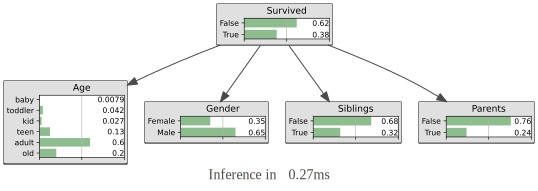

In [38]:
learner = gum.BNLearner("res/titanic/post_train.csv", bn)
bn = learner.learnParameters(bn.dag())
gnb.showInference(bn, size="10")

If we compare the CPTs obtained here with those defined by our expert in the first example we can see that they differ. They ressemble those obtained in the second example. This result is expected since we have learn the parameters from the training data, the learned probabilities distribution should match the data.

The final steps consists of confronting this model agains our test dataset.

res/titanic/post_train.csv: 100%|███████████████████████████████████████████████████████████|


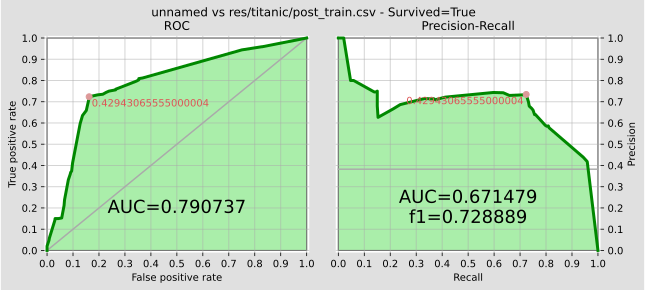

(0.7907371691846137,
 0.42943065555000004,
 0.67147855657751,
 0.42943065555000004)

In [42]:
showROC_PR(bn, "res/titanic/post_train.csv", 'Survived', "True", True, True)

In [43]:
ie = gum.LazyPropagation(bn)
init_belief(ie)
ie.addTarget('Survived')
result = testdf.apply(lambda x: is_well_predicted(ie, bn, 0.35917266477065596, x), axis=1)
result.value_counts(True)

True Positive     0.588517
True Negative     0.363636
False Negative    0.047847
dtype: float64

In [44]:
positives = sum(result.map(lambda x: 1 if x.startswith("True") else 0 ))
total = result.count()
print("{0:.2f}% good predictions".format(positives/total*100))

95.22% good predictions


Naive Bayes perform well when used for classification tasks, as shown by the 95% of good predictions achieved by our third model.

# Conclusion

We have demonstradted with different classification techniques using Bayesian networks. In the first approach, we mangaged to model a classifier without using any training set and relying solely on prior knowledge. In the second approach we used only machine learning techniques. Finally, in the third example we assumed the naive bayes hypothesis and obtained a model combinede